In [ ]:
 !pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

2748572632/2748572632 [==============================] - 22s 0us/step


In [ ]:
wavs_path= data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


In [ ]:
#Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|",header=None, quoting=3)

In [ ]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns = ["file_name","transcription","normalized_transcription"]
metadata_df=metadata_df[["file_name", "normalized_transcription"]]
metadata_df=metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ007-0085,at Newgate and York Castle as long as five yea...
1,LJ010-0290,The blow crushed the bonnet and bruised the fo...
2,LJ035-0001,Report of the President's Commission on the As...


we now split the data into training and validation set

In [ ]:
#Split=int(len(metadata_df)*0.30)
split=int(len(metadata_df)*0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"size of the training set: {len(df_train)}")
print(f"size of the training set: {len(df_val)}")

size of the training set: 11790
size of the training set: 1310


In [ ]:
#The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
#Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters,oov_token="")
#Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="", invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)



The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


Next,we create the function that describes the transformation that we apply to each element of our dataset

In [ ]:
char_to_num

In [ ]:
#An integer scalar Tensor.The window length in samples.
frame_length = 256
#An interger scalar Tensor.The number of samples to step
frame_step = 160
#An integer scalar Tensor .The size of the FFT to apply.
#If not provided,uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file,label):

#Process the audio

  #1.Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  #2. Decode the wav file
  audio, _=tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)
  #3. change type to float
  audio = tf.cast(audio, tf.float32)
  #4. Get the spectrogram
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  #5 we only need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  #Normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  # Process the label

  # 7. Convert label to lower case
  label = tf.strings.lower(label)
  # 8. split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")
  # 9. Map the characters in label to numbers
  label = char_to_num(label)
  # 10. Return a dict as our model is expecting two inputs
  return spectrogram,label

Creating dataset objects

we create a tf.data.Dataset object that yields the trasformed elements,in the same order as they appeared in the input

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)




#Define validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

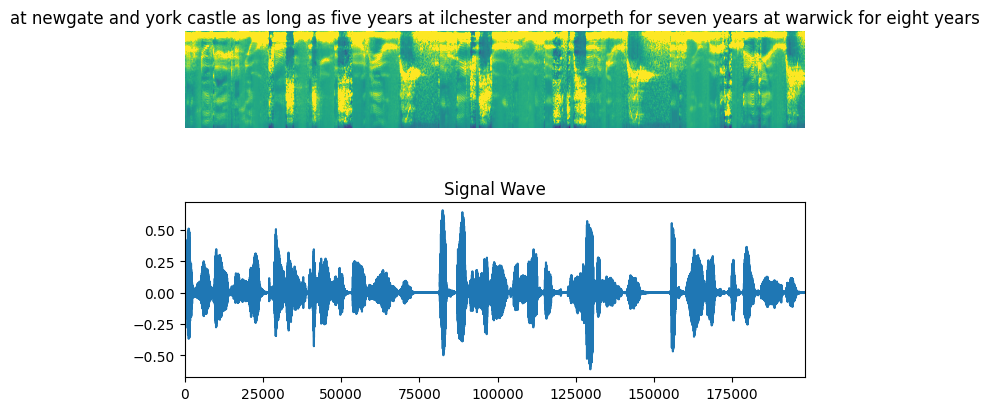

In [ ]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]
  # spectrogram
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")
  #wav
  file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
  audio, _=tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


In [ ]:
def CTCLoss(y_true, y_pred):
  #compute the training-time lose value
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss


We now define our model. We will define a model similar to Deepspeech2

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  """Model similar to Deepspeech2."""
  #Model's input
  input_spectrogram = layers.Input((None, input_dim), name="input")
  #Expand the dimension to use 2D CNN.
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
  # convolution layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2, 2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  # convolution layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1, 2],
      padding="Same",
      use_bias=False,
      name="conv_2",
   )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  # Reshape the resulted volume to feed the RNNs layers
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  # RNN layers
  for i in range(1, rnn_layers + 1):
      recurrent = layers.GRU(
           units=rnn_units,
           activation="tanh",
           recurrent_activation="sigmoid",
           use_bias=True,
           return_sequences=True,
           reset_after=True,
        name=f"gru_{i}",
      )
      x = layers.Bidirectional(
          recurrent, name=f"biodirectional_{i}", merge_mode="concat"
      )(x)
      if i < rnn_layers:
          x = layers.Dropout(rate=0.5)(x)
  #Dense layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)
  #Classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
  #Model
  model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
  #optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  # compile the model and return
  model.compile(optimizer=opt, loss=CTCLoss)
  return model

#Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)







Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

Training and Evaluating

In [ ]:
#A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    #use greedy search.for complex tasks,you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    #Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

#A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Display a batch of outputs after each epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-"* 100)
        print(f"word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)



Lets start the training process

In [ ]:
#Define the number of epochs
epochs = 4
# callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/4
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : a bricklayer found a human trunk near some new buildings in the edgeware road one morning in the last week of eighteen thirtysix
Prediction: ss
----------------------------------------------------------------------------------------------------
Target    : and the theft might have remained a mystery but for the subsequent bad faith of pierce to his accomplice agar
Prediction: sss
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1964s 5s/step - loss: 300.7081 - val_loss: 285.0160
Epoch 2/4
1/1 [==============================] - 1s 673ms/step
------------------------------------------------------------

Inference

In [ ]:
#Let's chaeck results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
  X, y = batch
  batch_predictions = model .predict(X)
  batch_predictions = decode_batch_predictions(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y:
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
      targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)